Using device: cuda


Training Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Episode 0, Total Reward: 1.2472808619499929, Path Length: 500
Episode 100, Total Reward: -28.608219836319343, Path Length: 500
Episode 200, Total Reward: -636.9910845096288, Path Length: 500
Episode 300, Total Reward: -2.112060535214037, Path Length: 500
Episode 400, Total Reward: -1.1747498580942213, Path Length: 500
Episode 500, Total Reward: -701.9039137710347, Path Length: 500
Episode 600, Total Reward: -0.3746138536636163, Path Length: 500
Episode 700, Total Reward: -2.051569120628877, Path Length: 500
Episode 800, Total Reward: -2.5224031519502517, Path Length: 500
Episode 900, Total Reward: -0.1084482534225198, Path Length: 500


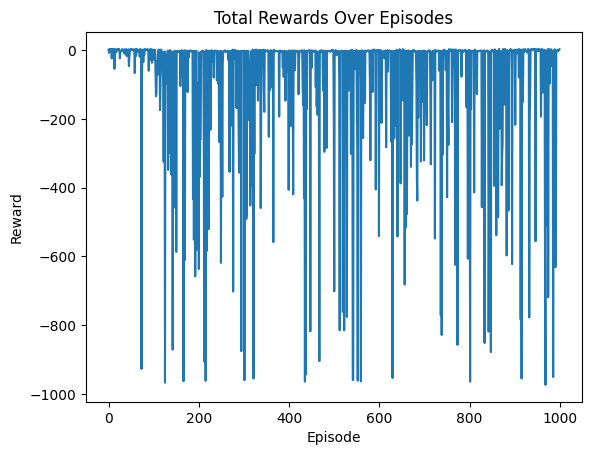

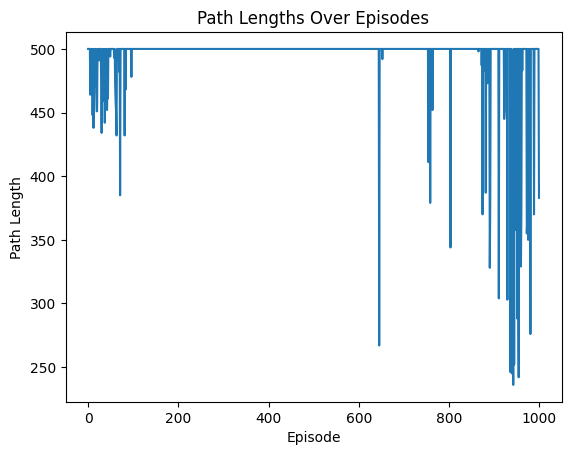

모델이 성공적으로 로드되었습니다.


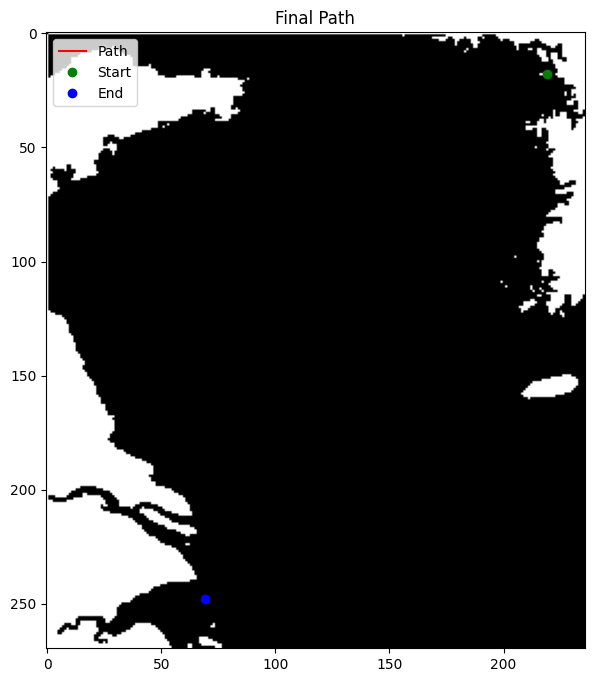

최종 경로의 시각화와 디버깅 데이터가 저장되었습니다.


In [13]:
import numpy as np
from numba import jit, float64, int64, boolean
from datetime import datetime, timedelta
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 경험 저장을 위한 named tuple 정의
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

# Dueling DQN 네트워크 정의
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# SumTree 클래스
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def add(self, priority, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, priority)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get(self, s):
        idx = 0
        while True:
            left = 2 * idx + 1
            right = left + 1
            if left >= len(self.tree):
                break
            if s <= self.tree[left]:
                idx = left
            else:
                s -= self.tree[left]
                idx = right
        data_idx = idx - self.capacity + 1
        return idx, self.tree[idx], self.data[data_idx]

    def total(self):
        return self.tree[0]

# Numba로 최적화된 연료 소비 계산 함수
@jit(nopython=True)
def calculate_fuel_consumption(abs_action_angle, position, tidal_grid_dir, tidal_grid_speed, tidal_grid_valid, 
                               wind_grid_dir, wind_grid_speed, wind_grid_valid, n_rows, n_cols, f_0=1, V_s=6.68):
    row, col = position
    tidal_dir, tidal_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and tidal_grid_valid[row, col]:
        tidal_dir = tidal_grid_dir[row, col]
        tidal_speed = tidal_grid_speed[row, col]
    wind_dir, wind_speed = 0.0, 0.0
    if 0 <= row < n_rows and 0 <= col < n_cols and wind_grid_valid[row, col]:
        wind_dir = wind_grid_dir[row, col]
        wind_speed = wind_grid_speed[row, col]
    
    tidal_dir_rad = (90.0 - tidal_dir) * np.pi / 180.0
    wind_dir_rad = (90.0 - wind_dir) * np.pi / 180.0
    action_angle_rad = (90.0 - abs_action_angle) * np.pi / 180.0
    
    theta_c = action_angle_rad - tidal_dir_rad
    theta_w = action_angle_rad - wind_dir_rad
    
    tidal_effect = (V_s - tidal_speed * np.cos(theta_c)) / V_s
    if tidal_effect <= 0:
        tidal_effect = 0.001
    f_tidal = f_0 * (tidal_effect ** 3)
    
    wind_effect = (V_s - wind_speed * np.cos(theta_w)) / V_s
    f_wind = f_0 * (wind_effect ** 2)
    
    total_fuel = f_tidal + f_wind
    return total_fuel

# Numba로 최적화된 거리 계산 함수
@jit(nopython=True)
def calculate_distance(end_pos, current_pos):
    rel_pos = end_pos - current_pos
    return np.linalg.norm(rel_pos)

# Numba로 최적화된 각도 계산 함수
@jit(nopython=True)
def calculate_angle(rel_pos):
    return (np.degrees(np.arctan2(rel_pos[1], -rel_pos[0])) % 360.0)

# Numba로 최적화된 그리드 방향 함수
@jit(nopython=True)
def angle_to_grid_direction(abs_action_angle, grid_angles):
    angle_diff = np.abs(grid_angles - abs_action_angle)
    closest_idx = np.argmin(angle_diff)
    return closest_idx

# 항해 환경 클래스
class NavigationEnv:
    def __init__(self):
        self.grid = np.load('land_sea_grid_cartopy_downsized.npy')
        self.n_rows, self.n_cols = self.grid.shape  # 270, 236
        self.lat_min, self.lat_max = 30.0, 38.0
        self.lon_min, self.lon_max = 120.0, 127.0
        self.start_pos = self.latlon_to_grid(37.46036, 126.52360)
        self.end_pos = self.latlon_to_grid(30.62828, 122.06400)
        self.step_time_minutes = 8.5
        self.max_steps = 500
        self.cumulative_time = 0
        self.step_count = 0
        self.tidal_data_dir = r"C:\baramproject\tidal_database_interpolated"
        self.wind_data_dir = r"C:\baramproject\wind_database_interpolated"
        self.action_space = np.array([-90, -45, 0, 45, 90], dtype=np.float64)
        self.current_direction = 0.0
        self.grid_directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315], dtype=np.float64)
        self.f_0 = 1.0
        self.V_s = 6.68
        self.path = []
        self.tidal_cache = {}
        self.wind_cache = {}
        self.executor = ThreadPoolExecutor(max_workers=2)  # 비동기 처리를 위한 ThreadPoolExecutor
        self.tidal_future = None
        self.wind_future = None
        self.reset()

    def latlon_to_grid(self, lat, lon):
        row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
        col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols)
        return row, col

    def reset(self, start_time=None):
        start_date = datetime(2018, 1, 1, 0, 0)
        end_date = datetime(2018, 12, 29, 0, 0)
        if start_time is None:
            time_delta = (end_date - start_date).total_seconds()
            random_seconds = np.random.randint(0, int(time_delta / 60 / 30) + 1) * 30 * 60
            start_time = start_date + timedelta(seconds=random_seconds)
        
        self.current_pos = self.start_pos
        self.current_direction = 0.0
        self.visit_count = {}
        self.prev_action = None
        self.previous_direction = None
        self.current_time = start_time
        self.cumulative_time = 0
        self.load_tidal_data_async()  # 비동기 데이터 로딩 시작
        self.load_wind_data_async()
        self.get_tidal_data()  # 비동기 데이터 가져오기
        self.get_wind_data()
        self.map_tidal_to_grid()
        self.map_wind_to_grid()
        self.prev_distance = self.get_distance_to_end()
        self.initial_distance = self.get_distance_to_end()
        self.step_count = 0
        self.path = []
        return self._get_state()

    def get_relative_position_and_angle(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        distance = calculate_distance(np.array(self.end_pos, dtype=np.float64), np.array(self.current_pos, dtype=np.float64))
        end_angle = calculate_angle(rel_pos)
        return rel_pos, distance, end_angle

    def get_distance_to_end(self):
        return calculate_distance(np.array(self.end_pos, dtype=np.float64), np.array(self.current_pos, dtype=np.float64))

    def angle_to_grid_direction(self, abs_action_angle):
        closest_idx = angle_to_grid_direction(abs_action_angle, self.grid_angles)
        return self.grid_directions[closest_idx]

    def load_tidal_data_async(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        dir_file = os.path.join(self.tidal_data_dir, f"tidal_dir_{time_str}.npy")
        speed_file = os.path.join(self.tidal_data_dir, f"tidal_speed_{time_str}.npy")
        def load():
            if time_str in self.tidal_cache:
                return self.tidal_cache[time_str]
            elif os.path.exists(dir_file) and os.path.exists(speed_file):
                return {"dir": np.load(dir_file, mmap_mode='r'), "speed": np.load(speed_file, mmap_mode='r')}
            return None
        self.tidal_future = self.executor.submit(load)

    def get_tidal_data(self):
        if self.tidal_future:
            self.tidal_data = self.tidal_future.result()
            if self.tidal_data:
                time_str = self.current_time.strftime("%Y%m%d_%H%M")
                self.tidal_cache[time_str] = self.tidal_data
            self.tidal_future = None
        self.load_tidal_data_async()  # 다음 데이터 미리 로드

    def load_wind_data_async(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        dir_file = os.path.join(self.wind_data_dir, f"wind_dir_{time_str}.npy")
        speed_file = os.path.join(self.wind_data_dir, f"wind_speed_{time_str}.npy")
        def load():
            if time_str in self.wind_cache:
                return self.wind_cache[time_str]
            elif os.path.exists(dir_file) and os.path.exists(speed_file):
                return {"dir": np.load(dir_file, mmap_mode='r'), "speed": np.load(speed_file, mmap_mode='r')}
            return None
        self.wind_future = self.executor.submit(load)

    def get_wind_data(self):
        if self.wind_future:
            self.wind_data = self.wind_future.result()
            if self.wind_data:
                time_str = self.current_time.strftime("%Y%m%d_%H%M")
                self.wind_cache[time_str] = self.wind_data
            self.wind_future = None
        self.load_wind_data_async()  # 다음 데이터 미리 로드

    def map_tidal_to_grid(self):
        if self.tidal_data is not None:
            self.tidal_grid_dir = self.tidal_data["dir"]
            self.tidal_grid_speed = self.tidal_data["speed"]
            self.tidal_grid_valid = np.ones((self.n_rows, self.n_cols), dtype=np.bool_)
        else:
            self.tidal_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.tidal_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def map_wind_to_grid(self):
        if self.wind_data is not None:
            self.wind_grid_dir = self.wind_data["dir"]
            self.wind_grid_speed = self.wind_data["speed"]
            self.wind_grid_valid = np.ones((self.n_rows, self.n_cols), dtype=np.bool_)
        else:
            self.wind_grid_dir = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_speed = np.zeros((self.n_rows, self.n_cols), dtype=np.float64)
            self.wind_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=np.bool_)

    def step(self, action):
        self.step_count += 1
        rel_pos, distance, end_angle = self.get_relative_position_and_angle()
        rel_action_angle = self.action_space[action]
        abs_action_angle = (end_angle + rel_action_angle) % 360.0
        turn_penalty = 0.0
        if self.previous_direction is not None:
            angle_diff = min((abs_action_angle - self.previous_direction) % 360.0, 
                             (self.previous_direction - abs_action_angle) % 360.0)
            turn_penalty = angle_diff * 0.1
        move_dir = self.angle_to_grid_direction(abs_action_angle)
        new_pos = (self.current_pos[0] + move_dir[0], self.current_pos[1] + move_dir[1])
        
        current_fuel = calculate_fuel_consumption(abs_action_angle, self.current_pos, self.tidal_grid_dir, 
                                                  self.tidal_grid_speed, self.tidal_grid_valid, 
                                                  self.wind_grid_dir, self.wind_grid_speed, self.wind_grid_valid, 
                                                  self.n_rows, self.n_cols, self.f_0, self.V_s)
        
        moved = False
        if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):
            self.current_pos = new_pos
            self.path.append(self.current_pos)
            moved = True
        self.previous_direction = abs_action_angle
        self.prev_action = action
        
        self.cumulative_time += self.step_time_minutes
        if self.cumulative_time >= 30:
            next_time = self.current_time + timedelta(minutes=30)
            end_date = datetime(2018, 12, 31, 23, 30)
            if next_time <= end_date:
                self.current_time = next_time
                self.get_tidal_data()
                if self.tidal_data is None:
                    print(f"No tidal data for {self.current_time}. Terminating episode.")
                    return self._get_state(), -1000, True, {}
                self.map_tidal_to_grid()
                self.get_wind_data()
                if self.wind_data is None:
                    print(f"No wind data for {self.current_time}. Terminating episode.")
                    return self._get_state(), -1000, True, {}
                self.map_wind_to_grid()
            else:
                print("Warning: Time exceeds 2018 range. Terminating episode.")
                return self._get_state(), -1000, True, {}
            self.cumulative_time -= 30
        
        state = self._get_state()
        current_distance = self.get_distance_to_end()
        
        pos_key = tuple(self.current_pos)
        self.visit_count[pos_key] = self.visit_count.get(pos_key, 0) + 1
        visit_penalty = -self.visit_count[pos_key] * 0.5
        
        distance_reward = 0.0
        if self.initial_distance > 0:
            linear_reward = (1 - current_distance / self.initial_distance) * 50.0
            change_reward = (self.prev_distance - current_distance) * 10.0
            distance_reward = linear_reward + change_reward
        
        self.prev_distance = current_distance
        goal_reward = 10000.0 if current_distance <= 1.0 else 0.0
        
        fuel_penalty = -current_fuel * 0.05
        reward = (fuel_penalty * 0.7 + distance_reward * 1.8 - turn_penalty * 1.8 + goal_reward + visit_penalty) * 0.0001
        
        if not moved:
            reward -= 2.0
        
        done = (current_distance <= 1.0) or (self.step_count >= self.max_steps)
        return state, reward, done, {}

    def _get_state(self):
        row, col = self.current_pos
        state = []
        
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                r = row + dr
                c = col + dc
                if 0 <= r < self.n_rows and 0 <= c < self.n_cols:
                    map_info = self.grid[r, c]
                    tidal_speed = self.tidal_grid_speed[r, c] if self.tidal_grid_valid[r, c] else 0.0
                    tidal_dir = self.tidal_grid_dir[r, c] if self.tidal_grid_valid[r, c] else 0.0
                    wind_speed = self.wind_grid_speed[r, c] if self.wind_grid_valid[r, c] else 0.0
                    wind_dir = self.wind_grid_dir[r, c] if self.wind_grid_valid[r, c] else 0.0
                    distance_to_end = calculate_distance(np.array(self.end_pos, dtype=np.float64), 
                                                        np.array([r, c], dtype=np.float64))
                else:
                    map_info = 1.0
                    tidal_speed = 0.0
                    tidal_dir = 0.0
                    wind_speed = 0.0
                    wind_dir = 0.0
                    distance_to_end = 0.0
                
                state.extend([map_info, tidal_speed, tidal_dir, wind_speed, wind_dir, distance_to_end])
        
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        end_angle = calculate_angle(rel_pos)
        state.append(end_angle)
        
        return np.array(state, dtype=np.float64)

# DQN 에이전트 클래스
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = 0.001
        self.gamma = 0.99
        self.batch_size = 128  # 배치 크기 증가로 GPU 활용도 향상
        self.buffer_size = 10000
        self.target_update = 500
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 60000
        self.n_steps = 3
        self.alpha = 0.6
        self.beta_start = 0.4
        self.beta_end = 1.0
        self.beta_steps = 50000
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = SumTree(self.buffer_size)
        self.step_count = 0
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=3000, gamma=0.95)
        self.memory_counter = 0
        
    def select_action(self, state, epsilon):
        self.step_count += 1
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        max_priority = np.max(self.memory.tree[-self.memory.capacity:]) if self.memory.n_entries > 0 else 1.0
        self.memory.add(max_priority, experience)
        self.memory_counter += 1

    def sample_batch(self, beta):
        batch = []
        idxs = []
        priorities = []
        segment = self.memory.total() / self.batch_size
        for i in range(self.batch_size):
            a, b = segment * i, segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.memory.get(s)
            batch.append(data)
            idxs.append(idx)
            priorities.append(p)
        sampling_probabilities = np.array(priorities) / self.memory.total()
        weights = (self.memory.n_entries * sampling_probabilities) ** (-beta)
        weights /= weights.max()
        return batch, idxs, torch.FloatTensor(weights).to(device)

    def compute_n_step_target(self, batch, idxs):
        batch_size = len(batch)
        states = torch.FloatTensor(np.array([e.state for e in batch])).to(device)
        actions = torch.LongTensor([e.action for e in batch]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
        next_states = torch.FloatTensor(np.array([e.next_state for e in batch])).to(device)
        dones = torch.FloatTensor([e.done for e in batch]).to(device)
    
        targets = rewards.clone()
        for i in range(1, self.n_steps):
            future_idxs = [idx + i for idx in idxs if idx + i < self.memory_counter]
            if future_idxs:
                future_batch = []
                valid_future_idxs = []
                for idx in future_idxs:
                    if idx < self.memory.n_entries + self.memory.capacity - 1:
                        future_batch.append(self.memory.data[idx % self.memory.capacity])
                        valid_future_idxs.append(idx)
                
                if len(future_batch) > 0:
                    future_rewards = torch.FloatTensor([e.reward for e in future_batch]).to(device)
                    future_dones = torch.FloatTensor([e.done for e in future_batch]).to(device)
                    mask = torch.zeros(batch_size, dtype=torch.bool, device=device)
                    mask[:len(valid_future_idxs)] = True
                    targets[mask] += (self.gamma ** i) * future_rewards[:len(valid_future_idxs)] * (1 - future_dones[:len(valid_future_idxs)])
    
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            target_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets += (self.gamma ** self.n_steps) * target_q * (1 - dones)
    
        return states, actions, targets

    def compute_loss(self, batch, idxs, weights):
        if not batch:
            return torch.tensor(0.0, device=device, requires_grad=True)
        
        states, actions, targets = self.compute_n_step_target(batch, idxs)
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        td_errors = (q_values.detach() - targets).cpu().numpy()
        loss = (weights * (q_values - targets) ** 2).mean()
        for idx, td_error in zip(idxs, td_errors):
            priority = (abs(td_error) + 0.01) ** self.alpha
            self.memory.update(idx, priority)
        return loss

    def update(self):
        if self.memory.n_entries < self.batch_size + self.n_steps - 1:
            return
        beta = self.beta_start + (self.beta_end - self.beta_start) * min(1.0, self.step_count / self.beta_steps)
        batch, idxs, weights = self.sample_batch(beta)
        loss = self.compute_loss(batch, idxs, weights)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

# 학습 루프 정의
def train_dqn(env, agent, max_episodes=1000):
    rewards = []
    path_lengths = []
    epsilon = agent.epsilon_start
    image_dir = r"C:\baramproject\trained_model\new_sibal13\episode_debug_image"
    data_dir = r"C:\baramproject\trained_model\new_sibal13\episode_debug_data"
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    
    for episode in tqdm(range(max_episodes), desc="Training Episodes"):
        state = env.reset()
        total_reward = 0
        path_length = 0
        done = False
        debug_mode = episode % 500 == 0
        debug_data = [] if debug_mode else None
        
        while not done:
            epsilon = max(agent.epsilon_end, epsilon - (agent.epsilon_start - agent.epsilon_end) / agent.epsilon_decay)
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            q_values = agent.policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).detach().cpu().numpy().flatten()
            if debug_mode:
                debug_data.append({
                    "step": path_length,
                    "state": state.tolist(),
                    "action": action,
                    "reward": reward,
                    "next_state": next_state.tolist(),
                    "q_values": q_values.tolist(),
                    "epsilon": epsilon
                })
            agent.store_experience(state, action, reward, next_state, done)
            if path_length % 4 == 0:
                agent.update()
            state = next_state
            total_reward += reward
            path_length += 1
        
        rewards.append(total_reward)
        path_lengths.append(path_length)

        if debug_mode:
            with open(os.path.join(data_dir, f"episode_{episode}.json"), 'w') as f:
                json.dump(debug_data, f, indent=4)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Path Length: {path_length}")
            plt.figure(figsize=(10, 8))
            plt.imshow(env.grid, cmap='gray')
            path_array = np.array(env.path)
            plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
            plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
            plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
            plt.legend()
            plt.title(f"Episode {episode} Path")
            plt.savefig(os.path.join(image_dir, f"episode_{episode}.png"))
            plt.close()
    
    torch.save(agent.policy_net.state_dict(), r"C:\baramproject\trained_model\new_sibal13\navigation_model.pth")
    return rewards, path_lengths

# 메인 실행
if __name__ == "__main__":
    env = NavigationEnv()
    state_dim = 55  # 54 (기존) + 1 (종료점까지의 각도)
    action_dim = len(env.action_space)
    agent = DQNAgent(state_dim, action_dim)
    
    # 학습 실행
    rewards, path_lengths = train_dqn(env, agent)
    
    # 학습 결과 그래프 출력
    plt.plot(rewards)
    plt.title("Total Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    plt.plot(path_lengths)
    plt.title("Path Lengths Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Path Length")
    plt.show()

    # 학습 완료 후 모델 로드 및 경로 탐색
    model_path = r"C:\baramproject\trained_model\new_sibal13\navigation_model.pth"
    image_dir = r"C:\baramproject\trained_model\new_sibal13\episode_debug_image"
    data_dir = r"C:\baramproject\trained_model\new_sibal13\episode_debug_data"
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)

    if os.path.exists(model_path):
        agent.policy_net.load_state_dict(torch.load(model_path))
        agent.policy_net.eval()
        print("모델이 성공적으로 로드되었습니다.")
        
        state = env.reset()
        done = False
        path = [env.current_pos]
        debug_data = []
        step = 0
        while not done:
            action = agent.select_action(state, epsilon=0.0)
            next_state, reward, done, _ = env.step(action)
            q_values = agent.policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).detach().cpu().numpy().flatten()
            debug_data.append({
                "step": step,
                "state": state.tolist(),
                "action": action,
                "reward": reward,
                "next_state": next_state.tolist(),
                "q_values": q_values.tolist(),
                "epsilon": 0.0
            })
            path.append(env.current_pos)
            state = next_state
            step += 1
        
        plt.figure(figsize=(10, 8))
        plt.imshow(env.grid, cmap='gray')
        path_array = np.array(path)
        plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
        plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
        plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
        plt.legend()
        plt.title("Final Path")
        plt.savefig(os.path.join(image_dir, "final_route.png"))
        plt.show()
        
        with open(os.path.join(data_dir, "final_route.json"), 'w') as f:
            json.dump(debug_data, f, indent=4)
        print("최종 경로의 시각화와 디버깅 데이터가 저장되었습니다.")
    else:
        print("모델 파일을 찾을 수 없습니다. 먼저 모델을 학습시켜 주세요.")